<b>建议：做统计推断前，先对数据的分布（包括正态）、方差等做一些基础的检验，有利于进一步选择合适的统计推断方法。</b>

In [17]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import statsmodels.stats.proportion as smp
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

dir = "../../teaching/医学统计实操/"
print(os.listdir("../../teaching/医学统计实操/"))  # 确认路径正确

['.ipynb_checkpoints', '2.统计描述.ipynb', '1.绪论.ipynb', 'data', 'install.ipynb', '5.多组数值变量比较的假设检验.ipynb', '4.两组数值变量比较的假设检验.ipynb', '6.分类变量比较的假设检验.ipynb', '3.前置检验.ipynb']


In [3]:
df = pd.read_csv(dir+"data/心脏病诊断数据集（原数据）.csv",header=None) #读取csv文件，没有列名
df.columns = ["年龄","性别","胸痛类型","静息血压","血浆类固醇含量（mg/dl）","空腹血糖>120mg/dl","静息心电图结果","最高心率","运动型心绞痛","运动引起的ST下降","最大运动量时心电图ST的斜率","使用荧光染色法测定的主血管数","THAL","患病情况"]                                                 #添加列名
df.head(5)

,年龄,性别,胸痛类型,静息血压,血浆类固醇含量（mg/dl）,空腹血糖>120mg/dl,静息心电图结果,最高心率,运动型心绞痛,运动引起的ST下降,最大运动量时心电图ST的斜率,使用荧光染色法测定的主血管数,THAL,患病情况
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1


# <b>1.正态性和方差齐性检验</b>

正态性检验： H0 ： x是正态分布     H1 ：X非正态分布  （X数组）
当p值大于α，接受H0；p值小于α ，不能接受H0

方差齐性检验： H0 ： V1=V2   H2 ：V1 ！= V2      （方差）
当p值大于α，接受H0；p值小于α ，不能接受H0

In [7]:
stats.kstest(df.年龄,'norm')   #正态性检验

KstestResult(statistic=1.0, pvalue=0.0)

In [14]:
female_hb = df[df["性别"] == 0]["空腹血糖>120mg/dl"]
male_hb = df[df["性别"] == 1]["空腹血糖>120mg/dl"]
stats.levene(female_hb,female_hb)    #方差齐性

LeveneResult(statistic=0.0, pvalue=1.0)

#  <b>2. 批量分布检验</b>

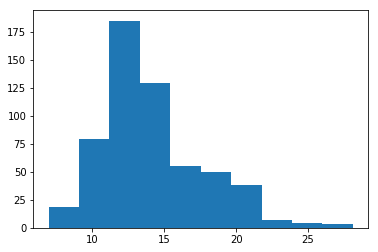

In [32]:
data_set = datasets.load_breast_cancer()   #乳腺癌数据集
y=data_set.data[:,0]
x = np.arange(len(y))   #序号
size = len(y)
plt.hist(y)
plt.show()

In [33]:
y_df = pd.DataFrame(y, columns=['Data'])  #转成数据框格式，方便使用pandas方法
y_df.describe()

,Data
count,569.000000
mean,14.127292
std,3.524049
min,6.981000
25%,11.700000
50%,13.370000
75%,15.780000
max,28.110000


In [34]:
sc=StandardScaler()   #标准化
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)  
y_std = y_std.flatten()
y_std
del yy

In [35]:
#先对数据进行分箱，利用卡方检验进行推断
dist_names = ['beta',   #  候选分布
              'expon',
              'gamma',
              'lognorm',
              'norm',  
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []   #分箱
p_values = []
percentile_bins = np.linspace(0,100,51)  #分箱，
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)


In [36]:
# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
 

/srv/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [37]:
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     30.426685  0.17957
2        gamma     44.960532  0.06151
5     pearson3     44.961716  0.06152
0         beta     48.102181  0.06558
4         norm    292.430764  0.00000
6       triang    532.742597  0.00000
7      uniform   2150.558410  0.00000
1        expon   5701.446012  0.00000
9  weibull_max  10452.188968  0.00000
8  weibull_min  12002.386769  0.00000


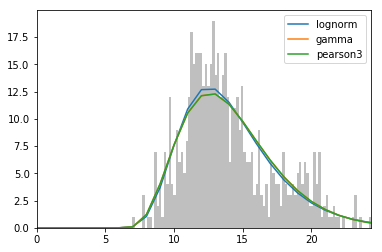


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.3411670333611477, 4.067737189292493, 9.490709944326486)

Distribution: gamma
Parameters: (5.252232022713325, 6.175162625863668, 1.5140473798580563)

Distribution: pearson3
Parameters: (0.8726704680754525, 14.127306804909308, 3.4698385545042782)


In [38]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

qq 和 pp图是两种查看数据分布拟合效果的两种方式（基础的是直方图）。散点分布与对角线重合得越紧，数据就越有可能服从该分布。

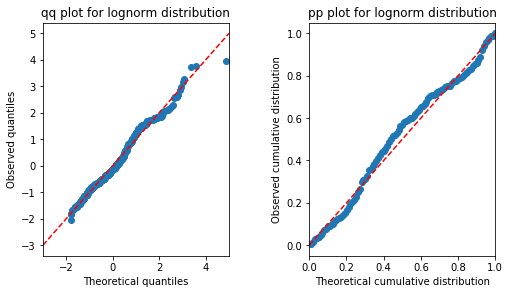

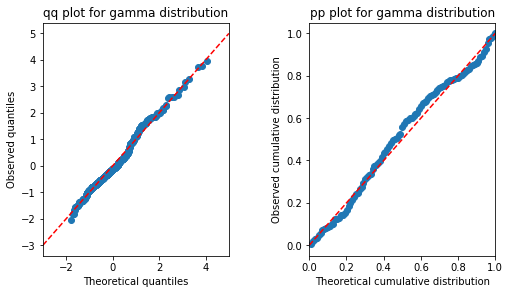

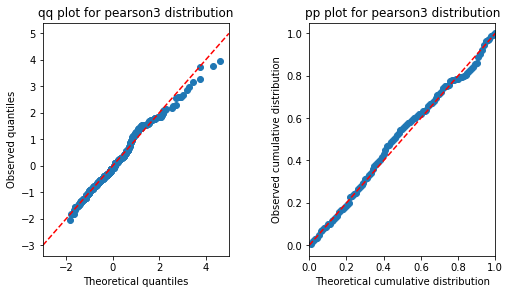

In [39]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()

# <b> 3. 置信区间 </b>

the 95% confidence intervals on the proportion

In [12]:
lower, upper = smp.proportion_confint (35, 120, alpha=0.05, method='normal')
print ('Lower confidence interval:', lower)
print ('Upper confidence interval:', upper)

Lower confidence interval: 0.21034248403748906
Upper confidence interval: 0.3729908492958443
